## 概要
- Poseを使った異常検知をMNISTでテストしてみる

## モジュールのインポート

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.layers import Input, Dense, Layer, BatchNormalization, Dropout, RepeatVector
from keras.layers import Lambda, Conv2D, Flatten, MaxPooling2D
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D, TimeDistributed
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Model
from keras import backend as K
#from keras import objectives
from keras.losses import binary_crossentropy
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, Callback
import tensorflow as tf
from scipy.stats import norm
from sklearn.model_selection import train_test_split

from glob import glob
from multiprocessing import Pool
import multiprocessing as mp
from tqdm import tqdm_notebook as tqdm
from time import time
import datetime
import os

Using TensorFlow backend.


## データの前処理

In [2]:
!ls ../data/shogi_pose_dataset/

AbemaTV_Tournament_Final1	 fujii_vs_kondo_Ablock_2_2_1080p
AbemaTV_Tournament_Final2	 fujii_vs_takami_semi_1_1080p
AbemaTV_Tournament_Final3	 fujii_vs_takami_semi_2_1080p
fujii_vs_kondo_Ablock_1_1080p	 fujii_vs_takami_semi_3_1080p
fujii_vs_kondo_Ablock_2_1_1080p


In [3]:
dirs_path = sorted(glob("../data/shogi_pose_dataset/AbemaTV_Tournament_Final*"))
# data_path = sorted(glob("../data/shogi_pose_dataset/AbemaTV_Tournament_Final1/*"))

In [4]:
flag = True
for dir_path in dirs_path:
    if flag:
        data_path = sorted(glob(os.path.join(dir_path, "*")))
        flag = False
    else:
        data_path += sorted(glob(os.path.join(dir_path, "*")))

In [5]:
def read_img(path):
    cv2.setNumThreads(0)
    img = cv2.imread(path, 0)
    size = 32
    
    
    # openposeのミスをできるだけ前処理で落とす
    try:
        x, w, y, h = trimming(img)
        margin = 16
        img_trim = img[y-margin:h+margin, x-margin:w+margin]
        height, width = img_trim.shape
        
        if (height < 150) or (width < 150):
            return np.zeros((size, size))
        
        # 膨張処理
        kernel = np.ones((6,6),np.uint8)
        img_trim = cv2.bitwise_not(img_trim) # 白(255)を膨張させるため反転
        img_dil = cv2.dilate(img_trim,kernel,iterations = 1)
        
        img_dil = cv2.resize(img_dil, (size, size))
        
        # 2値化
        _,img_bin = cv2.threshold(img_dil,0,1,cv2.THRESH_BINARY)
        
        return img_bin * 255.0
    except:
        return np.zeros((size, size))

In [6]:
def trimming(img):
    mask = img < 255
    x = np.where(np.sum(mask, axis=0) > 1)[0]
    y = np.where(np.sum(mask, axis=1) > 1)[0]
    
    x_min, x_max = x[0], x[-1]
    y_min, y_max = y[0], y[-1]
    return x_min, x_max, y_min, y_max

In [7]:
imgs = []
with tqdm(total=len(data_path)) as pbar:
    with Pool(mp.cpu_count()) as p:
        for img in tqdm(p.imap_unordered(read_img, data_path)):
            imgs.append(img)
            pbar.update()

### 画像をフレームごとに分割
- フレーム(0.5秒)のデータを5フレームごとにスライドしてデータを作成する。

In [8]:
stride = 5
time = 5

vids = []
for idx in tqdm(range((len(imgs) // 5) - 1)):
    vids.append(np.array(imgs[idx * stride: time + idx * stride]))
    
del imgs
del data_path

In [9]:
batch_size = 4

In [10]:
vids[-1].shape

(5, 32, 32)

In [11]:
np.array(vids).shape

(5893, 5, 32, 32)

In [12]:
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
(X_train, X_test, y_train, y_test) = train_test_split(np.array(vids), np.array([0 for _ in range(len(vids))]), test_size=0.2, random_state=98)

In [13]:
# X_train = X_train[np.where(y_train == 0)[0]]
# y_train = [0 for _ in range(len(np.where(y_train == 0)[0]))]
# X_test = X_test[np.where(y_test == 0)[0]]
# y_test = [0 for _ in range(len(np.where(y_test == 0)[0]))]

In [14]:
X_train.shape

(4714, 5, 32, 32)

In [15]:
X_test.shape

(1179, 5, 32, 32)

In [16]:
# 前処理
X_train = X_train[:X_train.shape[0] // batch_size * batch_size].astype("float32") / 255
X_test = X_test[:X_test.shape[0] // batch_size * batch_size].astype("float32") / 255

train_num, time, height, width = X_train.shape
test_num = X_test.shape[0]

X_train = X_train.reshape(train_num, time, height, width, 1)
X_test = X_test.reshape(test_num, time, height, width, 1)

print(X_train.shape, X_test.shape)

(4712, 5, 32, 32, 1) (1176, 5, 32, 32, 1)


## モデルの構築

In [17]:
K.clear_session()

In [18]:
kernel_size = 3
filters = 32
add_filter_size = 32
n_hidden = 512
z_dim = 2

In [19]:
def sampling(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(K.shape(z_mean)[0],
                                K.int_shape(z_mean)[1]), 
                          mean=0., 
                          stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * eps

In [20]:
# エンコーダ
inputs = Input(shape=(X_train.shape[1:]))
x = inputs

for _ in range(3):
    x = ConvLSTM2D(filters=filters,
               kernel_size=(kernel_size, kernel_size),
               strides=2,
               activation='relu',
               padding='same',
               return_sequences=True)(x)

    x = BatchNormalization()(x)
    filters += add_filter_size

# x = Conv3D(filters=1, kernel_size=(kernel_size,kernel_size,kernel_size),
#           activation="relu", padding="same", data_format="channels_last")(x)

shape_before_flat = K.int_shape(x)
x = Flatten()(x)


x = Dense(n_hidden, activation="relu")(x)
x = BatchNormalization()(x)


z_mean = Dense(z_dim, name="z_mean")(x)
z_log_var = Dense(z_dim, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 32, 32, 1) 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)     (None, 5, 16, 16, 32 38144       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 5, 16, 16, 32 128         conv_lst_m2d_1[0][0]             
__________________________________________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)     (None, 5, 8, 8, 64)  221440      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [21]:
# デコーダ
latent_inputs = Input(shape=(z_dim,), name="z_sampling")

z_decoded = Dense(n_hidden, activation="relu")(latent_inputs)
z_decoded = BatchNormalization()(z_decoded)

z_decoded = Dense(np.prod(shape_before_flat[1:]), activation="relu")(z_decoded)
z_decoded = Reshape(shape_before_flat[1:])(z_decoded)

# z_decoded = RepeatVector(time)(z_decoded)

# # z_decode = Conv3D(filters=1, kernel_size=(kernel_size,kernel_size,kernel_size),
# #           activation="relu", padding="same", data_format="channels_last")(z_decoded)

for _ in range(3):
    filters -= add_filter_size
    z_decoded = ConvLSTM2D(filters=filters,
               kernel_size=(kernel_size, kernel_size),
               activation='relu',
               padding='same',
               return_sequences=True)(z_decoded)
    z_decoded = TimeDistributed(UpSampling2D(size=(2,2)))(z_decoded)
    z_decoded = BatchNormalization()(z_decoded)

outputs = ConvLSTM2D(filters=1,
               kernel_size=(kernel_size, kernel_size),
               activation='relu',
               padding='same',
               return_sequences=True)(z_decoded)
    
#decoder = Model(latent_inputs, [outputs1, outputs2], name="decoder")
decoder = Model(latent_inputs, outputs, name="decoder")
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1536      
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 7680)              3939840   
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 4, 4, 96)       0         
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 5, 4, 4, 96)       663936    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 8, 8, 96)       0         
__________

In [22]:
# VAE model
# outputs_mu, outputs_sigma_2 = decoder(encoder(inputs)[2])
# vae = Model(inputs, [outputs_mu, outputs_sigma_2], name='vae_mlp')
outputs_decoder = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs_decoder, name='vae_mlp')

- kl_loss
    - カルバック・ライブラー情報量
    - 確率論と情報理論を組み合わせた２つの確率分布がどの程度似ているかを表す尺度

$$ loss = \frac{1}{2} \sum^{N_z}_{j=1} (\mu^{2}_{z_j} + \sigma^{2}_{z_j} - \log{\sigma^2_{z_j} - 1}) \\ = \frac{1}{2} \cdot \sum^{N_z}_{j=1} (\mu^{2}_{z_j} + \exp(\log{\sigma}) - \log{\sigma} - 1)?$$

> https://qiita.com/shinmura0/items/811d01384e20bfd1e035

In [23]:
# # loss
# m_vae_loss = (K.flatten(inputs) - K.flatten(outputs_mu))**2 / K.flatten(outputs_sigma_2)
# m_vae_loss = 0.5 * K.sum(m_vae_loss)

# a_vae_loss = K.log(2 * np.pi * K.flatten(outputs_sigma_2))
# a_vae_loss = 0.5 * K.sum(a_vae_loss)

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.mean(K.sum(kl_loss, axis=-1))
kl_loss *= -0.5

reconstruction_loss = K.sum(binary_crossentropy(K.flatten(inputs), K.flatten(outputs_decoder))) * width * height

vae_loss = reconstruction_loss + kl_loss

In [24]:
# build model
vae.add_loss(vae_loss)
vae.compile(optimizer="rmsprop")
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 32, 32, 1)      0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4750468   
_________________________________________________________________
decoder (Model)              (None, 5, 32, 32, 1)      5088936   
Total params: 9,839,404
Trainable params: 9,836,588
Non-trainable params: 2,816
_________________________________________________________________


### Tensorboardによる監視

In [25]:
!mkdir -p ../tmp

In [26]:
class TensorBoardImage(Callback):
    def __init__(self, model, tag, now):
        super().__init__() 
        self._model = model
        self._tag = tag
        self._now = now
        
    def tf_summary_image(self, img):
        import io
        from PIL import Image
        img = img.astype(np.uint8)
        
        height, width, channel = img.shape if len(img.shape) == 3 else (img.shape[0], img.shape[1], 1)
        
        image = Image.fromarray(img)
        with io.BytesIO() as output:
            
            image.save(output, format="PNG")
            image_string = output.getvalue()
        return tf.Summary.Image(height=height,
                               width=width,
                               colorspace=channel,
                               encoded_image_string=image_string)

    def decode_image(self):
        n = 15 # figure with 15x15 digits
        digit_size = 32
        figure = np.zeros((digit_size * n, digit_size * n))

        grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
        grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi]])
                x_decoded = self._model.predict(z_sample)[0]
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
        
        figure *= 255
        return figure
    
    def on_epoch_end(self, epoch, logs={}):
        # Do something to the image
        pose_dist = self.decode_image()
        image = self.tf_summary_image(pose_dist)
        summary = tf.Summary(value=[tf.Summary.Value(tag=self._tag, image=image)])
        with tf.summary.FileWriter('/home/nvidia/Desktop/Research/tmp/vid_vaeimg_{}'.format(str_now)) as writer:
            writer.add_summary(summary, epoch)
            
        return

In [41]:
now = datetime.datetime.now()
str_now = now.strftime('%Y%m%d_%H%M%S')

In [42]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, mode="auto")
tb_cb = TensorBoard(log_dir='/home/nvidia/Desktop/Research/tmp/vid_vaelog_{}'.format(str_now),
                    write_images=True, 
                    write_grads=True, 
                    write_graph=True)
mc_cb = ModelCheckpoint("/home/nvidia/Desktop/Research/output/vid_vae_best_param.hdf5",
                       monitor="val_loss",
                       verbose=1,
                       save_best_only=True,
                       mode="auto")
tbi_cb = TensorBoardImage(decoder, "pose distribution", str_now)
print(str_now)

20190107_044432


In [43]:
cbks = [es_cb, tb_cb, mc_cb, tbi_cb]

### 学習

In [44]:
n_epochs = 1000

In [45]:
vae.save_weights("../output/vid_vae_init_param_{}.hdf5".format(str_now))

In [46]:
json_string = vae.to_json()
with open("../output/vid_vae_model_{}.json".format(str_now), "w") as json_model:
    json_model.write(json_string)

In [47]:
#vae.load_weights("../output/vae_best_param.hdf5")

In [ ]:
history = vae.fit(X_train,
        shuffle=True,
        epochs=n_epochs,
        batch_size=batch_size,
        validation_data=(X_test, None),
        verbose=0,
        callbacks=cbks)

In [34]:
vae.save_weights("../output/vid_vae_best_param_{}.hdf5".format(str_now))

In [35]:
pred = decoder.predict(np.array([[0.9, 0.9]]))[0].reshape(5,32,32)

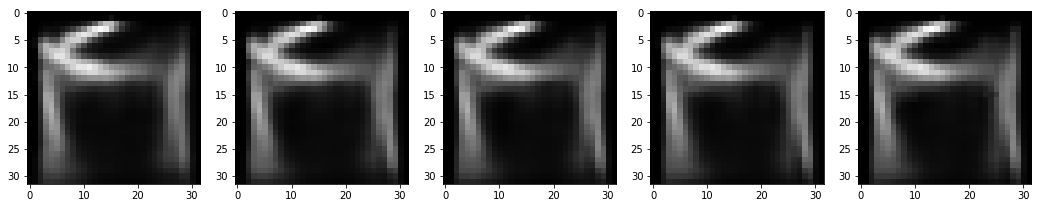

In [36]:
fig, ax = plt.subplots(ncols=5, figsize=(18,10))
for i in range(5):
    ax[i].imshow(pred[i], cmap="gray")
plt.show()

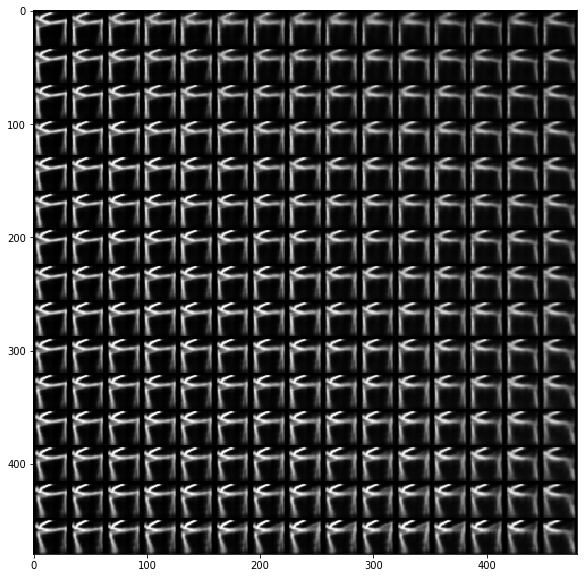

In [37]:
# display a 2D manifold of the digits
# 0 に対して分布を見てみる
n = 15 # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)[0]
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

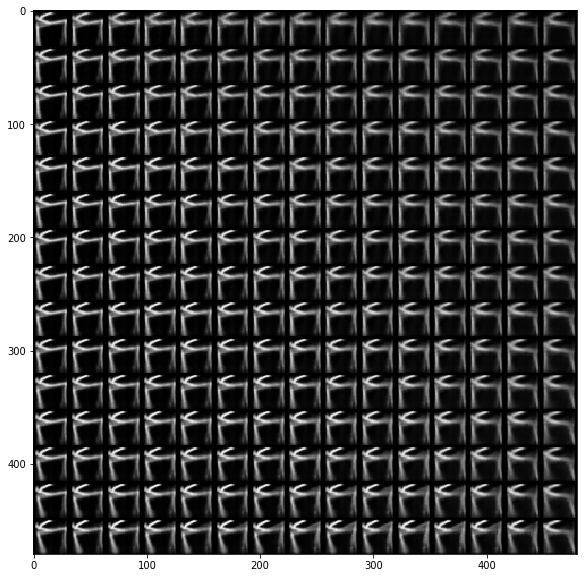

In [38]:
# display a 2D manifold of the digits
# 0 に対して分布を見てみる
n = 15 # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)[0]
        digit = x_decoded[4].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

## まとめ
VAEによる1種類の生成モデルを学習させることで1枚の画像の分布を得ることができるのでこれを用いて画像比較ができる。